<a href="https://colab.research.google.com/github/bigarcia/especializacao-pece-monografia/blob/main/Monografia_Explora%C3%A7%C3%A3o_e_Testes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pipeline de clusterização para segmentação de clientes com base em características financeiras.

- Verificação da qualidade dos dados
- Normalização com `StandardScaler`
- Clusterização com `KMeans` e validação via `Silhouette Score`
- Visualização 2D com PCA
- Análise descritiva por cluster

# Limpeza dos dados

In [ ]:
# pip install -r requirements.txt

## Imports

In [ ]:
from pyspark.sql.functions import col, when, count, trim, sum, avg
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler
from functools import reduce

## Inicia Spark Session

In [ ]:
spark = SparkSession.builder \
    .appName("Data Cleaning") \
    .config("spark.jars", "/home/ec2-user/jars/hadoop-aws-3.3.4.jar,/home/ec2-user/jars/aws-java-sdk-bundle-1.12.375.jar") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", "com.amazonaws.auth.DefaultAWSCredentialsProviderChain") \
    .getOrCreate()


## Leitura do arquivo

In [ ]:
s3_input_path = "/content/credit_risk_dataset.csv"
df = spark.read.csv(s3_input_path, header=True, inferSchema=True)
df.show(5)

In [ ]:
df.printSchema()

## Análise dos dados

In [ ]:
categorical_cols = [c for c, t in df.dtypes if t == "string"]
numeric_cols = [c for c, t in df.dtypes if t in ["double", "int"]]

In [ ]:
print(f"Total de registros: {df.count()}")


In [ ]:
df.select(
    "person_age", "person_income", "person_emp_length",
    "loan_amnt", "loan_int_rate", "loan_percent_income",
    "cb_person_cred_hist_length"
).describe().show()


 Distribuição de classes-alvo (loan_status)

In [ ]:
df.groupBy("loan_status").count().show()

Valores únicos e frequência de colunas categóricas

In [ ]:
# categorical_cols = [
#     "person_home_ownership", "loan_intent", "loan_grade",
#     "cb_person_default_on_file"
# ]

# categorical_cols = [c for c, t in df.dtypes if t == "string"]


In [39]:

for col_name in categorical_cols:
    print(f"\nValores únicos em '{col_name}':")
    df.groupBy(col_name).count().orderBy("count", ascending=False).show()



Valores únicos em 'person_home_ownership':
+---------------------+-----+
|person_home_ownership|count|
+---------------------+-----+
|                 RENT|16446|
|             MORTGAGE|13444|
|                  OWN| 2584|
|                OTHER|  107|
+---------------------+-----+


Valores únicos em 'loan_intent':
+-----------------+-----+
|      loan_intent|count|
+-----------------+-----+
|        EDUCATION| 6453|
|          MEDICAL| 6071|
|          VENTURE| 5719|
|         PERSONAL| 5521|
|DEBTCONSOLIDATION| 5212|
|  HOMEIMPROVEMENT| 3605|
+-----------------+-----+


Valores únicos em 'loan_grade':
+----------+-----+
|loan_grade|count|
+----------+-----+
|         A|10777|
|         B|10451|
|         C| 6458|
|         D| 3626|
|         E|  964|
|         F|  241|
|         G|   64|
+----------+-----+


Valores únicos em 'cb_person_default_on_file':
+-------------------------+-----+
|cb_person_default_on_file|count|
+-------------------------+-----+
|                        N|

 Valores nulos por coluna

In [40]:

df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|         0|            0|                    0|              895|          0|         0|        0|         3116|          0|                  0|                        0|                         0|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+



Distribuição de variáveis numéricas

Quantos nulos existem por linha


In [41]:

# Lista de colunas do DataFrame
columns = df.columns

# Soma dos valores nulos por linha
null_expr = reduce(
    lambda acc, c: acc + when(col(c).isNull(), 1).otherwise(0),
    columns[1:],  # começa da segunda coluna
    when(col(columns[0]).isNull(), 1).otherwise(0)  # inicia com a primeira
)

df_with_nulls = df.withColumn("null_count", null_expr)

# Exibir as linhas com mais de (total de colunas - 3) nulos
df_with_nulls.filter(col("null_count") > (len(columns) - 3)).show(truncate=False)


+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+----------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|null_count|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+----------+
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+----------+



Distribuição de valores nulos por linha

In [42]:
df_with_nulls.groupBy("null_count").count().orderBy("null_count", ascending=False).show()


+----------+-----+
|null_count|count|
+----------+-----+
|         2|   68|
|         1| 3875|
|         0|28638|
+----------+-----+



## Remove Duplicatas

In [43]:
# Verificar se há registros duplicados
print(f"Número de linhas distintas: {df.distinct().count()}")
print(f"Número de linhas antes: {df.count()}")

# Exibir registros duplicados, se houver
df.groupBy(df.columns).count().filter("count > 1").show()

Número de linhas distintas: 32416
Número de linhas antes: 32581
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-----+
|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|count|
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-----+
|        24|        39000|                 RENT|              8.0|          MEDICAL|         D|     1500|        15.62|          0|               0.04|                        Y|                         3|    2|
|        30|        52800|                 RENT|              4.0|         PERSONAL|        

In [44]:
df = df.dropDuplicates()

In [45]:
print(f"Número de linhas depois: {df.count()}")

Número de linhas depois: 32416


## Remove Valores Nulos

- Colunas numéricas: preencher com a mediana

In [46]:
# numeric_cols = [
#     "person_age", "person_income", "person_emp_length",
#     "loan_amnt", "loan_int_rate", "loan_percent_income",
#     "cb_person_cred_hist_length"
# ]


In [47]:
df.select([count(when(col(c).isNull(), c)).alias(c + "_nulls") for c in numeric_cols
]).show()

+----------------+-------------------+-----------------------+---------------+-------------------+-----------------+-------------------------+--------------------------------+
|person_age_nulls|person_income_nulls|person_emp_length_nulls|loan_amnt_nulls|loan_int_rate_nulls|loan_status_nulls|loan_percent_income_nulls|cb_person_cred_hist_length_nulls|
+----------------+-------------------+-----------------------+---------------+-------------------+-----------------+-------------------------+--------------------------------+
|               0|                  0|                    887|              0|               3095|                0|                        0|                               0|
+----------------+-------------------+-----------------------+---------------+-------------------+-----------------+-------------------------+--------------------------------+



In [48]:
# Mostrar registros com nulos em colunas numéricas
df.filter(
    " OR ".join([f"{c} IS NULL" for c in numeric_cols])
).show(5)

+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|        21|        19253|             MORTGAGE|             null|DEBTCONSOLIDATION|         A|     6250|         6.17|          1|               0.32|                        N|                         3|
|        22|        50400|                 RENT|              3.0|          VENTURE|         B|     2000|         null|          0|               0.04|                        N|   

In [49]:
for c in numeric_cols:
    median = df.approxQuantile(c, [0.5], 0.001)[0]
    df = df.fillna({c: median})

df.show()

+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|        24|        60000|                 RENT|              3.0|          VENTURE|         C|    22000|        14.26|          1|               0.37|                        Y|                         2|
|        21|        19000|                  OWN|              5.0|          MEDICAL|         A|     6000|         8.49|          1|               0.32|                        N|   

- Colunas categóricas: preencher com "Unknown"

In [50]:

df.select([
    count(when(col(c).isNull(), c)).alias(c + "_nulls") for c in categorical_cols
]).show()

+---------------------------+-----------------+----------------+-------------------------------+
|person_home_ownership_nulls|loan_intent_nulls|loan_grade_nulls|cb_person_default_on_file_nulls|
+---------------------------+-----------------+----------------+-------------------------------+
|                          0|                0|               0|                              0|
+---------------------------+-----------------+----------------+-------------------------------+



In [51]:
# Mostrar registros com nulos em colunas categóricas
df.filter(
    " OR ".join([f"{c} IS NULL" for c in categorical_cols])
).show(5)


+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+



In [52]:
df = df.fillna({c: "Unknown" for c in categorical_cols})

## Remove Outliers

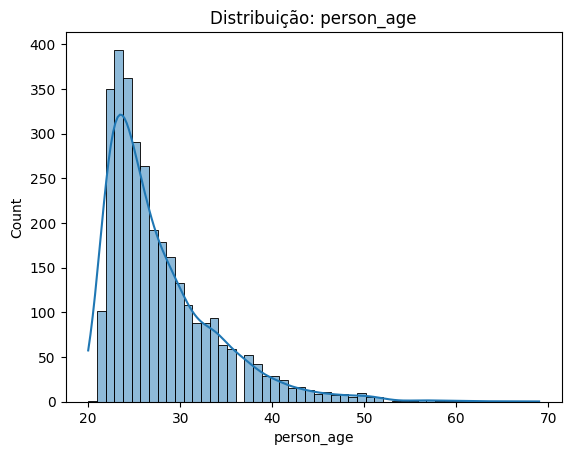

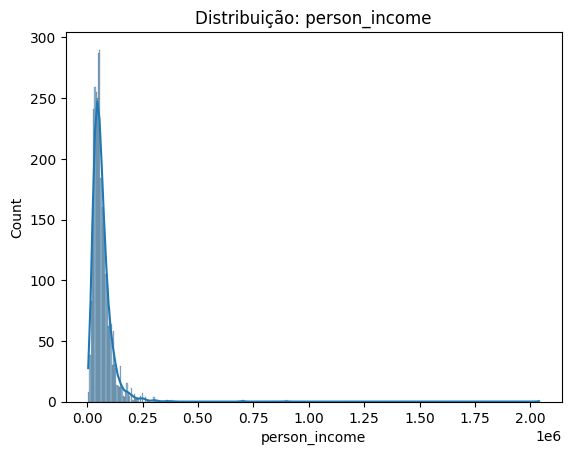

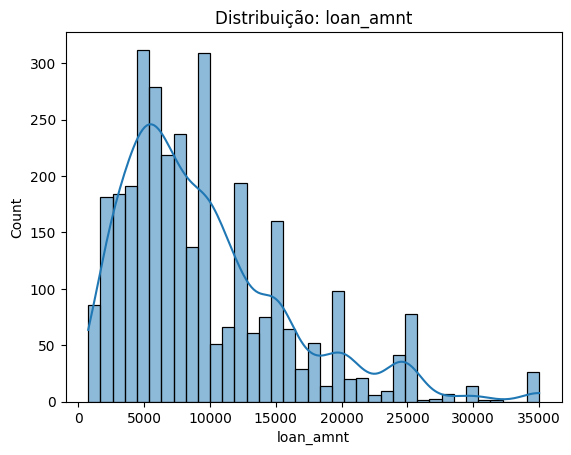

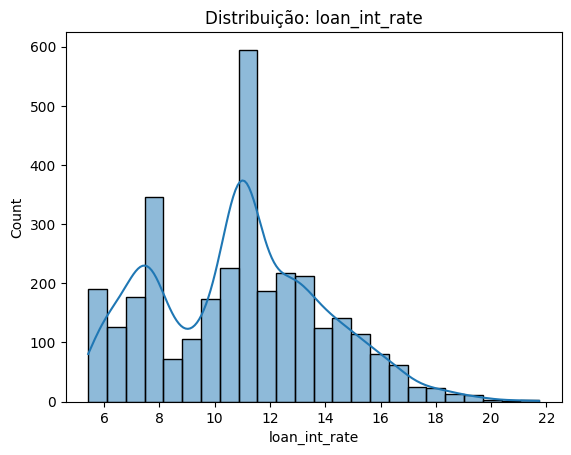

In [53]:
sample_pd = df.sample(fraction=0.1, seed=42).toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ["person_age", "person_income", "loan_amnt", "loan_int_rate"]

for columns in numeric_cols:
    sns.histplot(sample_pd[columns].dropna(), kde=True)
    plt.title(f"Distribuição: {columns}")
    plt.show()


In [54]:
df.describe(["person_age", "person_income", "loan_amnt", "loan_int_rate"]).show()


+-------+-----------------+-----------------+-----------------+------------------+
|summary|       person_age|    person_income|        loan_amnt|     loan_int_rate|
+-------+-----------------+-----------------+-----------------+------------------+
|  count|            32416|            32416|            32416|             32416|
|   mean|27.74700765054294|66091.64082551826|9593.845631786771|11.014661895359184|
| stddev| 6.35409994731211|62015.58026889566|6322.730240861562|3.0830504659623936|
|    min|               20|             4000|              500|              5.42|
|    max|              144|          6000000|            35000|             23.22|
+-------+-----------------+-----------------+-----------------+------------------+



Idade deve ser entre 18 e 100

In [55]:
df.filter((col("person_age") < 18) | (col("person_age") > 100)).show()

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|       144|      6000000|             MORTGAGE|             12.0|   PERSONAL|         C|     5000|        12.73|          0|                0.0|                        N|                        25|
|       123|        80004|                 RENT|              2.0|  EDUCATION|         B|    20400|        10.25|          0|               0.25|                        N|                         3|
|    

In [56]:
df = df.filter((col("person_age") >= 18) & (col("person_age") <= 100))

In [57]:
df.filter((col("person_age") < 18) | (col("person_age") > 100)).show()

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+



Renda deve ser > 0

In [58]:
df.filter(col("person_income") <= 0).show()

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+



In [59]:
df = df.filter(col("person_income") > 0)

In [60]:
df.filter(col("person_income") <= 0).show()

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+



### loan_int_rate
Taxa de juros deve ser positiva e menor que 100%

In [61]:
df.groupBy("loan_int_rate").count().orderBy("loan_int_rate").show(truncate = False)

+-------------+-----+
|loan_int_rate|count|
+-------------+-----+
|5.42         |588  |
|5.79         |395  |
|5.99         |353  |
|6.0          |12   |
|6.03         |444  |
|6.17         |214  |
|6.39         |62   |
|6.54         |250  |
|6.62         |412  |
|6.76         |176  |
|6.91         |263  |
|6.92         |206  |
|6.99         |337  |
|7.05         |19   |
|7.12         |8    |
|7.14         |333  |
|7.29         |381  |
|7.37         |34   |
|7.4          |66   |
|7.42         |8    |
+-------------+-----+
only showing top 20 rows



In [62]:
df.select("loan_int_rate").summary("min", "max").show()


+-------+-------------+
|summary|loan_int_rate|
+-------+-------------+
|    min|         5.42|
|    max|        23.22|
+-------+-------------+



In [63]:
df.groupBy("loan_int_rate").count().orderBy("loan_int_rate").show(truncate = False)

+-------------+-----+
|loan_int_rate|count|
+-------------+-----+
|5.42         |588  |
|5.79         |395  |
|5.99         |353  |
|6.0          |12   |
|6.03         |444  |
|6.17         |214  |
|6.39         |62   |
|6.54         |250  |
|6.62         |412  |
|6.76         |176  |
|6.91         |263  |
|6.92         |206  |
|6.99         |337  |
|7.05         |19   |
|7.12         |8    |
|7.14         |333  |
|7.29         |381  |
|7.37         |34   |
|7.4          |66   |
|7.42         |8    |
+-------------+-----+
only showing top 20 rows



In [64]:
df.filter((col("loan_int_rate") < 0) | (col("loan_int_rate") > 100)).show()

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+



In [65]:
df = df.filter((col("loan_int_rate") >= 0) & (col("loan_int_rate") <= 100))

In [66]:
df.filter((col("loan_int_rate") < 0) | (col("loan_int_rate") > 100)).show()

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+



loan_percent_income = proporção da renda mensal comprometida com o empréstimo.

loan_percent_income = loan_amnt/
person_income

Se ela vale zero, isso indica que:

- O valor do empréstimo (loan_amnt) é zero
ou
- A renda (person_income) é infinita (não é o caso), ou
- Erro de cálculo ou inconsistência no dado



Percentual de renda comprometida com o empréstimo menor que 1 (100%)

In [67]:
df.filter((col("loan_percent_income") <= 0) | (col("loan_percent_income") > 1)).show()

+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|        42|      2039784|                 RENT|              0.0|          VENTURE|         C|     8450|        12.29|          0|                0.0|                        Y|                        15|
|        44|      1440000|             MORTGAGE|              7.0|DEBTCONSOLIDATION|         A|     6400|          7.4|          0|                0.0|                        N|   

In [68]:
df = df.withColumn(
    "loan_percent_income",
    when(
        col("loan_percent_income") == 0,
        (col("loan_amnt") / col("person_income")).cast("double")
    ).otherwise(col("loan_percent_income"))
)

In [69]:
df.filter(col("loan_percent_income") == 0).show()


+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+



Tempo de crédito
A coluna cb_person_cred_hist_length representa o número de anos de histórico de crédito que uma pessoa tem com a agência de crédito (Credit Bureau). É uma medida de maturidade financeira ou experiência de crédito do indivíduo.
Alguém com cb_person_cred_hist_length = 0 está começando agora ou não tem histórico registrado.

Ter um longo histórico geralmente aumenta a confiabilidade do cliente, pois fornece mais dados para prever seu comportamento financeiro. Em contraste, um histórico curto pode representar maior risco ou incerteza para instituições de crédito.

In [70]:
df.filter(
    (col("cb_person_cred_hist_length").isNull()) |
    (col("cb_person_cred_hist_length") < 1)
).show()

#isNull(): identifica registros onde o campo está ausente.

#< 1: identifica registros com valor igual a 0, ou negativo (caso existam).

+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+
+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+



In [71]:
df = df.filter(
    (col("cb_person_cred_hist_length").isNotNull()) &
    (col("cb_person_cred_hist_length") >= 1)
)

Rótulo loan_status:
Loan status (0 -bom is non default 1 - ruim is default)



In [72]:
df.select("loan_status").distinct().show()

+-----------+
|loan_status|
+-----------+
|          1|
|          0|
+-----------+



In [73]:
df = df.filter((col("loan_status") == 0) | (col("loan_status") == 1))

Valores nulos

In [74]:
df.select([
    count(when(col(c).isNull(), c)).alias(c + "_nulls") for c in df.columns
]).show()

+----------------+-------------------+---------------------------+-----------------------+-----------------+----------------+---------------+-------------------+-----------------+-------------------------+-------------------------------+--------------------------------+
|person_age_nulls|person_income_nulls|person_home_ownership_nulls|person_emp_length_nulls|loan_intent_nulls|loan_grade_nulls|loan_amnt_nulls|loan_int_rate_nulls|loan_status_nulls|loan_percent_income_nulls|cb_person_default_on_file_nulls|cb_person_cred_hist_length_nulls|
+----------------+-------------------+---------------------------+-----------------------+-----------------+----------------+---------------+-------------------+-----------------+-------------------------+-------------------------------+--------------------------------+
|               0|                  0|                          0|                      0|                0|               0|              0|                  0|                0|        

Analisar colunas categóricas com valores inválidos ou incompletos

In [75]:

for col_name in categorical_cols:
    print(f"Valores únicos da coluna {col_name}:")
    df.select(trim(col(col_name)).alias(col_name)).distinct().show()

Valores únicos da coluna person_home_ownership:
+---------------------+
|person_home_ownership|
+---------------------+
|                  OWN|
|                 RENT|
|             MORTGAGE|
|                OTHER|
+---------------------+

Valores únicos da coluna loan_intent:
+-----------------+
|      loan_intent|
+-----------------+
|DEBTCONSOLIDATION|
|          VENTURE|
|         PERSONAL|
|        EDUCATION|
|  HOMEIMPROVEMENT|
|          MEDICAL|
+-----------------+

Valores únicos da coluna loan_grade:
+----------+
|loan_grade|
+----------+
|         F|
|         E|
|         B|
|         D|
|         C|
|         A|
|         G|
+----------+

Valores únicos da coluna cb_person_default_on_file:
+-------------------------+
|cb_person_default_on_file|
+-------------------------+
|                        Y|
|                        N|
+-------------------------+



In [76]:
import pyspark.sql.functions as F

# Estatísticas descritivas
df.select(
    F.count("person_income").alias("count"),
    F.mean("person_income").alias("mean"),
    F.expr("percentile(person_income, array(0.5))")[0].alias("median"),
    F.stddev("person_income").alias("stddev"),
    F.min("person_income").alias("min"),
    F.expr("percentile(person_income, array(0.25))")[0].alias("p25"),
    F.expr("percentile(person_income, array(0.75))")[0].alias("p75"),
    F.expr("percentile(person_income, array(0.95))")[0].alias("p95"),
    F.expr("percentile(person_income, array(0.99))")[0].alias("p99"),
    F.max("person_income").alias("max")
).show(truncate=False)


+-----+-----------------+-------+------------------+----+-------+-------+--------+--------+-------+
|count|mean             |median |stddev            |min |p25    |p75    |p95     |p99     |max    |
+-----+-----------------+-------+------------------+----+-------+-------+--------+--------+-------+
|32411|65897.95516954121|55000.0|52520.934764518446|4000|38500.0|79200.0|138000.0|225000.0|2039784|
+-----+-----------------+-------+------------------+----+-------+-------+--------+--------+-------+



In [77]:
df.filter(col("person_income") > 300000).count()


136

Apenas 136 registros (de um total de mais de 32.000) possuem person_income > 300.000.

Eles representam menos de 0,5% do total, o que é estatisticamente irrelevante para o modelo, mas podem causar distorções se não forem removidos.

In [78]:
df.filter(col("person_income") > 300000).show()


+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+--------------------+-------------------------+--------------------------+
|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status| loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+--------------------+-------------------------+--------------------------+
|        42|      2039784|                 RENT|              0.0|          VENTURE|         C|     8450|        12.29|          0|0.004142595490502916|                        Y|                        15|
|        36|       430000|                 RENT|              2.0|        EDUCATION|         C|    25000|         13.8|          0|                0.06|                        

In [79]:
df = df.filter(col("person_income") <= 300000)

## Salvar no bucket
Dados limpos, com valores ausentes tratados, outliers removidos e tipos corrigidos.

Ainda não houve transformação de variáveis categóricas ou escala.

Ideal salvar neste ponto o resultado da limpeza para reuso.

In [80]:
# df_clean_path = "s3a://credit-risk/clean/credit_risk_cleaned.parquet"

# df.write.mode("overwrite").parquet(df_clean_path)

#Feature Engineering

Feature engineering completo: indexação, encoding, normalização, VectorAssembler, etc.

Serve de base para algoritmos de ML.

## 2. Definir colunas categóricas e numéricas


In [81]:
categorical_cols = [c for c, t in df.dtypes if t == "string"]
numeric_cols = [c for c, t in df.dtypes if t in ["double", "int"]]

In [82]:
# categorical_cols = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]
# numeric_cols = ["person_age", "person_income", "person_emp_length", "loan_amnt",
#                 "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"]

Antes de aplicar os algoritmos de clusterização e predição, precisamos transformar os dados para que:

Todas as variáveis estejam em formato numérico, pois os algoritmos de machine learning não trabalham com strings diretamente;

Os dados estejam normalizados ou padronizados (especialmente os numéricos) para garantir desempenho adequado do modelo.

## 3. Preparar indexação e codificação de colunas categóricas


StringIndexer:	Transforma strings categóricas em números (ex: "RENT" → 0, "OWN" → 1...)

In [83]:
indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_indexed", handleInvalid="keep")
    for c in categorical_cols
]

In [84]:
# numeric_cols = [c for c, t in df.dtypes if t in ["double", "int"]]


In [85]:
pipeline_indexers = Pipeline(stages=indexers)
df_indexed = pipeline_indexers.fit(df).transform(df)
df_indexed.select(categorical_cols + [c + "_indexed" for c in categorical_cols]).show(5)


+---------------------+-----------------+----------+-------------------------+-----------------------------+-------------------+------------------+---------------------------------+
|person_home_ownership|      loan_intent|loan_grade|cb_person_default_on_file|person_home_ownership_indexed|loan_intent_indexed|loan_grade_indexed|cb_person_default_on_file_indexed|
+---------------------+-----------------+----------+-------------------------+-----------------------------+-------------------+------------------+---------------------------------+
|                 RENT|          VENTURE|         C|                        Y|                          0.0|                2.0|               2.0|                              1.0|
|                  OWN|          MEDICAL|         A|                        N|                          2.0|                1.0|               0.0|                              0.0|
|             MORTGAGE|DEBTCONSOLIDATION|         A|                        N|            

In [86]:
# Opcional: OneHotEncoding (pode ser útil para algoritmos lineares, mas pode ser removido em RandomForest)
# Irei apenas indexar para reduzir complexidade e deixar o modelo mais leve
# Mas para uso de OneHotEncoder:
# encoders = [
#     OneHotEncoder(inputCol=col_name + "_indexed", outputCol=col_name + "_ohe")
#     for col_name in categorical_cols
# ]



## 4. Escalar colunas numéricas (normalização: média = 0, desvio = 1)

* StandardScaler:	Padroniza as variáveis numéricas para mesma escala
* VectorAssembler:	Junta as features em um vetor único para os modelos

In [87]:
assembler_numeric = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="numeric_features_assembled"
)

In [88]:
df_numeric_assembled = assembler_numeric.transform(df_indexed)
df_numeric_assembled.select(numeric_cols + ["numeric_features_assembled"]).show(5, truncate=False)

+----------+-------------+-----------------+---------+-------------+-----------+-------------------+--------------------------+-----------------------------------------------+
|person_age|person_income|person_emp_length|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_cred_hist_length|numeric_features_assembled                     |
+----------+-------------+-----------------+---------+-------------+-----------+-------------------+--------------------------+-----------------------------------------------+
|24        |60000        |3.0              |22000    |14.26        |1          |0.37               |2                         |[24.0,60000.0,3.0,22000.0,14.26,1.0,0.37,2.0]  |
|21        |19000        |5.0              |6000     |8.49         |1          |0.32               |3                         |[21.0,19000.0,5.0,6000.0,8.49,1.0,0.32,3.0]    |
|21        |19253        |4.0              |6250     |6.17         |1          |0.32               |3                   

StandardScaler: padronizando as variáveis numéricas para que tenham: média 0, desvio padrão 1.
O StandardScaler é totalmente apropriado para KMeans, porque:

* KMeans é sensível à escala das variáveis (usa distância euclidiana).

* Com withMean=True e withStd=True, a gente garante que todas as variáveis tenham o mesmo peso relativo no clustering.


In [89]:
scaler = StandardScaler(
    inputCol="numeric_features_assembled",
    outputCol="numeric_features_scaled",
    withMean=True,
    withStd=True
)

In [90]:
scaler_model = scaler.fit(df_numeric_assembled)
df_scaled = scaler_model.transform(df_numeric_assembled)
df_scaled.select("numeric_features_assembled", "numeric_features_scaled").show(5, truncate=False)

+-----------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|numeric_features_assembled                     |numeric_features_scaled                                                                                                                                        |
+-----------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[24.0,60000.0,3.0,22000.0,14.26,1.0,0.37,2.0]  |[-0.5980559665315834,-0.10340262828078407,-0.43084469397737446,1.9772386867349214,1.0534564645847926,1.8870830467220854,1.8672932409737018,-0.9385521493258695]|
|[21.0,19000.0,5.0,6000.0,8.49,1.0,0.32,3.0]    |[-1.0836147463150723,-1.1982207784660555,0.058880869005586506,-0.5669469348292191,-0.8180043373669225,1.8870830

## 5. Combinar features finais (categóricas indexadas + numéricas escaladas)


In [91]:
final_feature_cols = [c + "_indexed" for c in categorical_cols] + ["numeric_features_scaled"]

final_assembler = VectorAssembler(
    inputCols=final_feature_cols,
    outputCol="features"
)

In [92]:
df_final = final_assembler.transform(df_scaled)

df_final.select("features", "loan_status").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|features                                                                                                                                                                       |loan_status|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|[0.0,2.0,2.0,1.0,-0.5980559665315834,-0.10340262828078407,-0.43084469397737446,1.9772386867349214,1.0534564645847926,1.8870830467220854,1.8672932409737018,-0.9385521493258695]|1          |
|[2.0,1.0,0.0,0.0,-1.0836147463150723,-1.1982207784660555,0.058880869005586506,-0.5669469348292191,-0.8180043373669225,1.8870830467220854,1.398551393221735,-0.6908983814356461]|1          |
|[1.0,4.0,0.0,0.0,-1.0836147463150723,-1.191464949

## 6.Construir pipeline completo


Pipeline:	Automatiza o processo acima com um fit/transform
loan_status	Usado como label para algoritmos supervisionados

In [93]:
pipeline = Pipeline(stages=indexers + [assembler_numeric, scaler, final_assembler])

In [94]:
print(pipeline.getStages())

[StringIndexer_257c177d67af, StringIndexer_7230d96ee8cf, StringIndexer_6c0f5e079833, StringIndexer_d84b441347d2, VectorAssembler_f92292ca9032, StandardScaler_283aa0c63e9f, VectorAssembler_352268170341]


## 7. Treinar e transformar os dados


In [95]:
pipeline_model = pipeline.fit(df)
df_enriched = pipeline_model.transform(df)

# 8. Selecionar apenas o que importa para ML


loan_status: Usado como label para algoritmos supervisionados

In [96]:
df_enriched.select("features", "loan_status", *categorical_cols, *numeric_cols).show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+---------------------+-----------------+----------+-------------------------+----------+-------------+-----------------+---------+-------------+-----------+-------------------+--------------------------+
|features                                                                                                                                                                       |loan_status|person_home_ownership|loan_intent      |loan_grade|cb_person_default_on_file|person_age|person_income|person_emp_length|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_cred_hist_length|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+---------------------+---

In [97]:
df_enriched.show()

+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-----------------------------+-------------------+------------------+---------------------------------+--------------------------+-----------------------+--------------------+
|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|person_home_ownership_indexed|loan_intent_indexed|loan_grade_indexed|cb_person_default_on_file_indexed|numeric_features_assembled|numeric_features_scaled|            features|
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-----------------------------+------

## 9. Salvar como camada enriched


In [98]:
# df_enriched.write.mode("overwrite").parquet("s3a://credit-risk/enriched/credit_risk_enriched.parquet")


# Análise de importância das variáveis com Decision Tree
Podemos usar uma árvore de decisão para prever loan_status e extrair a importância das features, como nos notebooks do Kaggle:



In [99]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Montagem do vetor de features
feature_cols = ["person_age", "person_income", "person_emp_length", "loan_amnt", "loan_int_rate", "loan_percent_income"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Modelo
dt = DecisionTreeClassifier(labelCol="loan_status", featuresCol="features", maxDepth=5)

pipeline = Pipeline(stages=[assembler, dt])
model = pipeline.fit(df)

# Importância das features
importances = model.stages[-1].featureImportances

# Mostrar com nomes
for i, col_name in enumerate(feature_cols):
    print(f"{col_name}: {importances[i]:.4f}")


person_age: 0.0000
person_income: 0.1381
person_emp_length: 0.0367
loan_amnt: 0.0000
loan_int_rate: 0.2813
loan_percent_income: 0.5440


Usando os clusters gerados com KMeans, você pode fazer uma análise por grupo, como:
* Identificar clusters de risco elevado (como o cluster 2 que você já detectou).

* Comparar variáveis explicativas por grupo, como fizeram os notebooks do Kaggle.

#Clusterização com KMeans

In [100]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

## Treina o modelo de KMeans


In [101]:
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=4, seed=42)
kmeans_model = kmeans.fit(df_enriched)

## Aplica o modelo para obter os clusters


In [102]:
df_clustered = kmeans_model.transform(df_enriched)

In [103]:
df_clustered.groupBy("cluster").agg(
    F.avg("person_age").alias("avg_age"),
    F.avg("person_income").alias("avg_income"),
    F.avg("loan_amnt").alias("avg_loan"),
    F.avg("loan_int_rate").alias("avg_int_rate"),
    F.avg("loan_percent_income").alias("avg_percent_income"),
    F.avg("loan_status").alias("avg_default")
).orderBy("cluster").show()


+-------+------------------+------------------+------------------+------------------+-------------------+-------------------+
|cluster|           avg_age|        avg_income|          avg_loan|      avg_int_rate| avg_percent_income|        avg_default|
+-------+------------------+------------------+------------------+------------------+-------------------+-------------------+
|      0| 25.72230003112356| 63086.51828509181| 8602.703859321506| 10.07443821973266|0.15300497976968186|0.06847183317771553|
|      1|  26.4325939908762|54686.813276702844|12278.484347962876|14.542343872896168|0.24724555607991222| 0.7404436054742803|
|      2| 41.10579796772265| 71972.38643156007|   9762.7241482367| 10.84823670053807|0.15757023311416588| 0.1506276150627615|
|      3|26.512654320987654| 68130.46841563786| 8996.126543209877| 9.999258230452837|0.14894855967077889|0.10133744855967078|
+-------+------------------+------------------+------------------+------------------+-------------------+-------------

## Avalia os clusters com índice de Silhouette


In [104]:
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(df_clustered)
print(f"Silhouette Score: {silhouette:.4f}")

Silhouette Score: 0.2864


Como temos dados reais com certa complexidade, e estamos usando técnicas não supervisionadas (como K-Means), um Silhouette Score entre 0.3 e 0.6 já pode ser considerado aceitável.

Scores muito altos (>0.7) são raros com dados financeiros reais, pois os grupos tendem a se sobrepor naturalmente (ex: dois clientes diferentes podem ter renda parecida mas perfis distintos de risco).

## Contagem por cluster

In [105]:
df_clustered.groupBy("cluster").count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1| 6357|
|      3| 9720|
|      2| 3346|
|      0|12852|
+-------+-----+



## Média das variáveis por cluster (exemplo: person_income e loan_amnt)


In [106]:
df_clustered.groupBy("cluster").avg("person_income", "loan_amnt", "loan_int_rate").show()

+-------+------------------+------------------+------------------+
|cluster|avg(person_income)|    avg(loan_amnt)|avg(loan_int_rate)|
+-------+------------------+------------------+------------------+
|      1|54686.813276702844|12278.484347962876|14.542343872896168|
|      3| 68130.46841563786| 8996.126543209877| 9.999258230452837|
|      2| 71972.38643156007|   9762.7241482367| 10.84823670053807|
|      0| 63086.51828509181| 8602.703859321506| 10.07443821973266|
+-------+------------------+------------------+------------------+



Testar com k = 3, k = 4 e k = 5, avaliando:

* Silhouette Score

* Distribuição dos dados por cluster

* Média do loan_status (inadimplência) por cluster

In [107]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

for k in [3, 4, 5]:
    kmeans = KMeans(k=k, seed=42, featuresCol="features", predictionCol="cluster")
    model = kmeans.fit(df_enriched)
    df_kmeans = model.transform(df_enriched)

    evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette = evaluator.evaluate(df_kmeans)

    print(f"k = {k}, Silhouette Score = {silhouette:.4f}")

    # Contagem de registros por cluster
    df_kmeans.groupBy("cluster").count().show()

    # Média da inadimplência por cluster
    df_kmeans.groupBy("cluster").avg("loan_status").withColumnRenamed("avg(loan_status)", "avg_default").show()


k = 3, Silhouette Score = 0.2804
+-------+-----+
|cluster|count|
+-------+-----+
|      1|11161|
|      2|14099|
|      0| 7015|
+-------+-----+

+-------+-------------------+
|cluster|        avg_default|
+-------+-------------------+
|      1|0.09246483290027775|
|      2|0.06801900844031492|
|      0| 0.7248752672843906|
+-------+-------------------+

k = 4, Silhouette Score = 0.2864
+-------+-----+
|cluster|count|
+-------+-----+
|      1| 6357|
|      3| 9720|
|      2| 3346|
|      0|12852|
+-------+-----+

+-------+-------------------+
|cluster|        avg_default|
+-------+-------------------+
|      1| 0.7404436054742803|
|      3|0.10133744855967078|
|      2| 0.1506276150627615|
|      0|0.06847183317771553|
+-------+-------------------+

k = 5, Silhouette Score = 0.2561
+-------+-----+
|cluster|count|
+-------+-----+
|      1| 4493|
|      3| 3150|
|      4| 5262|
|      2| 9163|
|      0|10207|
+-------+-----+

+-------+--------------------+
|cluster|         avg_default|


In [108]:
df_kmeans.groupBy("cluster").agg(
    F.avg("person_age"),
    F.avg("person_income"),
    F.avg("loan_amnt"),
    F.avg("loan_percent_income"),
    F.avg("loan_int_rate"),
    F.avg("person_emp_length"),
).show()


+-------+------------------+------------------+------------------+------------------------+------------------+----------------------+
|cluster|   avg(person_age)|avg(person_income)|    avg(loan_amnt)|avg(loan_percent_income)|avg(loan_int_rate)|avg(person_emp_length)|
+-------+------------------+------------------+------------------+------------------------+------------------+----------------------+
|      1|26.511462274649453| 48577.39439127532|13261.072779879813|     0.29348097039839877| 13.62293567772083|     3.906966392165591|
|      3| 41.50476190476191| 70776.33174603175| 9731.436507936507|     0.15779999999999988|10.804717460317603|     6.489206349206349|
|      4|26.129608513873052| 63297.01843405549| 8912.894336754085|     0.15280311668567065|14.224566704675086|     4.436145952109464|
|      2|26.555822328931573| 69957.00632980464| 8935.105860526028|      0.1414449416130066|  9.93615628069422|     4.945869256793626|
|      0|25.783971784069756| 63308.62398354071|  8789.71784069

Selecionar o melhor modelo e salvar dataset enriquecido
Suponha que k = 4 foi o melhor (melhor silhouette + clusters interpretáveis). A seguir, mantenha esse modelo:

In [109]:
kmeans_final = KMeans(k=3, seed=42, featuresCol="features", predictionCol="cluster")
model_final = kmeans_final.fit(df_enriched)
df_clustered = model_final.transform(df_enriched)


#DBSCAN
Diferente do KMeans, o DBSCAN é baseado em densidade e não exige número de clusters pré-definido, o que pode ser útil para dados com formas irregulares.

⚠️ Importante: O DBSCAN não está disponível nativamente no MLlib do PySpark, então usaremos uma abordagem alternativa:

* Exportar os dados (features + label) para um Pandas DataFrame (amostrado);

* Aplicar DBSCAN com scikit-learn;

* Visualizar os clusters com matplotlib/seaborn;

* Interpretar os resultados.

In [110]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [111]:

# 1. Amostrar os dados para visualização (ex: 5% dos dados)
df_sample = df_enriched.sample(fraction=0.05, seed=42)


In [112]:
# 2. Converter para Pandas para usar sklearn
pdf = df_sample.select("features").toPandas()
X = pdf["features"].apply(lambda v: v.toArray()).tolist()

In [113]:
# 3. Escalar os dados para garantir que todas as dimensões estão na mesma escala
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [114]:
# 4. Aplicar DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=10)
labels = dbscan.fit_predict(X_scaled)

In [115]:

# 5. Reduzir para 2D com PCA para visualizar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

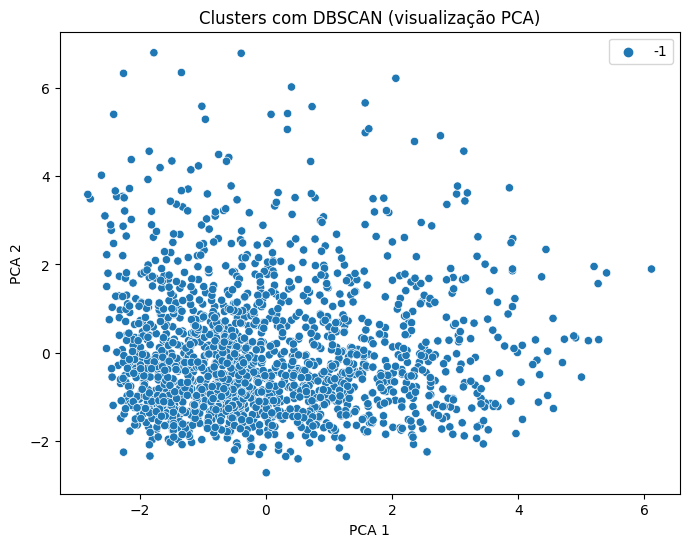

In [116]:
# 6. Visualizar com Seaborn
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="tab10", legend="full")
plt.title("Clusters com DBSCAN (visualização PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


Esse resultado indica que o DBSCAN classificou todos os pontos como ruído, atribuindo o rótulo -1 para todos. Isso significa que, com os parâmetros atuais (eps=0.8, min_samples=10), nenhum cluster foi encontrado.

O que isso revela:
O valor de eps (raio de vizinhança) provavelmente está pequeno demais, fazendo com que os pontos fiquem isolados uns dos outros, sem densidade suficiente para formar grupos;

min_samples=10 pode estar alto demais para o espaçamento entre os dados, principalmente após o StandardScaler.



In [117]:
from sklearn.metrics import silhouette_score
import numpy as np

best_model = None
best_score = -1
results = []

for eps in [0.5, 1.0, 1.5, 2.0]:
    for min_samples in [3, 5, 10]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters >= 2:
            score = silhouette_score(X_scaled, labels)
        else:
            score = -1

        results.append((eps, min_samples, n_clusters, score))

        if score > best_score:
            best_score = score
            best_model = dbscan

# Mostrar os melhores resultados
for r in results:
    print(f"eps: {r[0]}, min_samples: {r[1]}, clusters: {r[2]}, silhouette: {r[3]:.4f}")


eps: 0.5, min_samples: 3, clusters: 4, silhouette: -0.2893
eps: 0.5, min_samples: 5, clusters: 0, silhouette: -1.0000
eps: 0.5, min_samples: 10, clusters: 0, silhouette: -1.0000
eps: 1.0, min_samples: 3, clusters: 45, silhouette: -0.3090
eps: 1.0, min_samples: 5, clusters: 18, silhouette: -0.3010
eps: 1.0, min_samples: 10, clusters: 5, silhouette: -0.2521
eps: 1.5, min_samples: 3, clusters: 24, silhouette: -0.1029
eps: 1.5, min_samples: 5, clusters: 11, silhouette: -0.0772
eps: 1.5, min_samples: 10, clusters: 5, silhouette: -0.0717
eps: 2.0, min_samples: 3, clusters: 10, silhouette: 0.0875
eps: 2.0, min_samples: 5, clusters: 7, silhouette: 0.1075
eps: 2.0, min_samples: 10, clusters: 4, silhouette: 0.1246


O melhor resultado foi com: eps=2.0 e min_samples=10

Apesar do silhouette score ainda ser baixo (0.1295), ele é o melhor encontrado com pelo menos 4 clusters válidos.

Isso é comum com DBSCAN quando os dados não possuem uma estrutura de densidade muito clara — ou estão muito bem normalizados (como foi feito com StandardScaler).



In [118]:
dbscan = DBSCAN(eps=2.0, min_samples=10)


In [119]:
import pandas as pd
pd.Series(labels).value_counts()

,0
0,1014
-1,351
2,162
1,110
3,19


DBSCAN identificou um núcleo de clientes (cluster 0) com densidade alta, além de alguns subgrupos menores (clusters 1, 2, 3).

343 registros foram considerados outliers (cluster -1), ou seja, não fazem parte de nenhum grupo denso. Isso reforça a força do DBSCAN em detectar pontos fora do padrão.

Clusters pequenos (ex: 2 com 57 registros) podem representar perfis financeiros extremos ou específicos.

In [120]:
df_clustered[df_clustered["cluster"] != -1].groupby("cluster").mean()


DataFrame[cluster: int, avg(person_age): double, avg(person_income): double, avg(person_emp_length): double, avg(loan_amnt): double, avg(loan_int_rate): double, avg(loan_status): double, avg(loan_percent_income): double, avg(cb_person_cred_hist_length): double, avg(person_home_ownership_indexed): double, avg(loan_intent_indexed): double, avg(loan_grade_indexed): double, avg(cb_person_default_on_file_indexed): double, avg(cluster): double]

In [121]:
df_clustered.groupBy("cluster").agg(
avg("loan_status").alias("avg_default")
).orderBy("cluster").show()

+-------+-------------------+
|cluster|        avg_default|
+-------+-------------------+
|      0| 0.7248752672843906|
|      1|0.09246483290027775|
|      2|0.06801900844031492|
+-------+-------------------+



A segmentação via KMeans resultou em três grupos com perfis bem distintos de inadimplência. O Cluster 0 concentra a maior parte dos clientes inadimplentes, com mais de 72% de inadimplência média, o que o caracteriza como um grupo de altíssimo risco. Em contrapartida, os clusters 1 e 2 apresentam níveis muito mais baixos, com 9,2% e 6,8%, respectivamente, sugerindo perfis mais saudáveis do ponto de vista financeiro. Esses resultados reforçam a utilidade da clusterização para identificar segmentos com diferentes níveis de risco de crédito, permitindo direcionar políticas específicas de cobrança, concessão ou monitoramento.

Para visualizar os clusters de forma clara, especialmente com muitas variáveis, o ideal é reduzir a dimensionalidade dos dados usando PCA (Análise de Componentes Principais) e depois plotar os pontos em 2D com cores representando os clusters.



#PCA

1. Executar PCA para reduzir a dimensionalidade


In [122]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_clustered)
df_pca = pca_model.transform(df_clustered)

2. Converter para Pandas para plotar


In [123]:
# Coletar só os dados necessários
df_plot = df_pca.select("pca_features", "cluster").toPandas()

# Separar coordenadas x e y
df_plot["x"] = df_plot["pca_features"].apply(lambda v: float(v[0]))
df_plot["y"] = df_plot["pca_features"].apply(lambda v: float(v[1]))


3. Plotar com matplotlib


A projeção bidimensional via PCA permite visualizar a separação entre os grupos formados pelo algoritmo KMeans, com base nas variáveis financeiras e socioeconômicas padronizadas dos clientes.

Os eixos do gráfico PCA representam combinações lineares das variáveis originais do dataset, maximizando a variabilidade dos dados em dois componentes principais. O primeiro componente (PCA 1) concentra a maior parte da variância, enquanto o segundo (PCA 2) representa a segunda direção mais informativa e independente. Essa transformação permite visualizar os agrupamentos formados pelo algoritmo de clusterização, facilitando a distinção entre perfis de risco distintos mesmo em um espaço reduzido a duas dimensões.



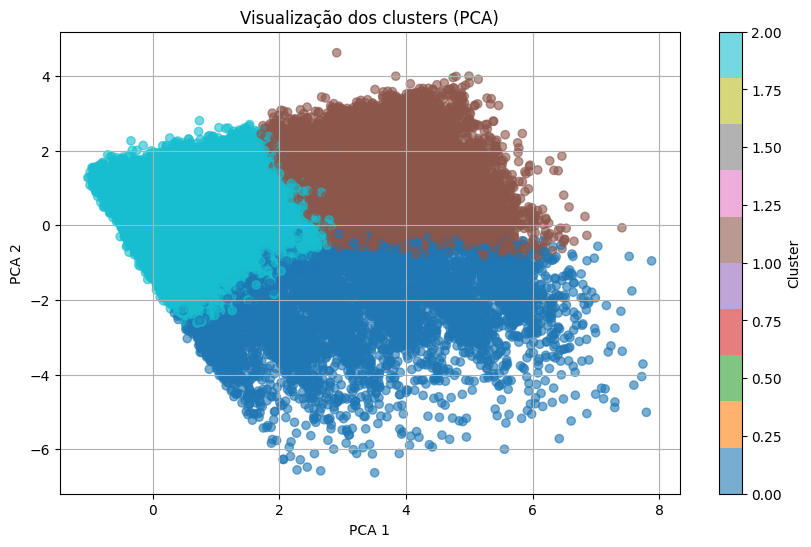

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_plot["x"], df_plot["y"], c=df_plot["cluster"], cmap="tab10", alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Visualização dos clusters (PCA)")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()


O gráfico mostra três clusters distintos:

Cluster 0 (em azul escuro): concentra a maior parte dos pontos na região inferior do gráfico, com predominância de valores negativos no eixo PCA 2. Isso sugere que esse grupo tem características específicas que o afastam dos demais, podendo refletir clientes com perfis de menor renda ou maior comprometimento da renda com o empréstimo — a ser confirmado na análise descritiva.

Cluster 1 (em marrom): ocupa majoritariamente a parte superior direita do gráfico, indicando um grupo mais homogêneo e separado dos demais ao longo do eixo PCA 2. Pode representar um segmento de clientes com melhores condições financeiras ou taxas de juros mais baixas, dependendo da combinação das variáveis que mais influenciaram os componentes principais.

Cluster 2 (em ciano): está distribuído principalmente à esquerda do gráfico, com menor densidade e mais dispersão que os outros clusters. Essa dispersão pode refletir um grupo mais heterogêneo ou intermediário, com características mistas entre os outros dois clusters.

O gráfico mostra uma separação razoável entre os grupos, o que indica que o algoritmo KMeans conseguiu identificar padrões distintos de comportamento financeiro entre os clientes. No entanto, há alguma sobreposição entre os clusters — algo esperado em dados reais, onde os limites entre perfis não são perfeitamente definidos.

# Random Forest

Após a etapa de clusterização, aplicou-se um modelo supervisionado de classificação utilizando o algoritmo Random Forest, com o objetivo de prever a inadimplência dos clientes com base em suas características financeiras e comportamentais.

O Random Forest é um ensemble de árvores de decisão que oferece alta robustez contra overfitting e bom desempenho preditivo, especialmente em bases com múltiplas variáveis numéricas e categóricas.

Modelo supervisionado que terá como objetivo prever a variável loan_status com base nos atributos disponíveis.

loan_status deve ser 0 para adimplente e 1 para inadimplente, como no seu dataset.

O Random Forest pode lidar bem com variáveis numéricas e categóricas (desde que indexadas).

Para avaliação, é usada a Área sob a Curva ROC, mas podemos adicionar outras métricas como precisão, recall e F1.

# 1. Indexação da variável alvo (label)
Transforma loan_status em uma coluna numérica chamada label, necessária para modelos supervisionados.

In [141]:
from pyspark.ml.feature import StringIndexer

# Transforma 'loan_status' em numérico: 1 (inadimplente), 0 (adimplente)
indexer_label = StringIndexer(inputCol="loan_status", outputCol="label")
df_rf = indexer_label.fit(df_enriched).transform(df_enriched)


# 2. Seleção de features numéricas e categóricas indexadas
Define as colunas que serão usadas como preditoras.


In [142]:
# Lista de variáveis de entrada (features)
feature_cols = [
    "person_age", "person_income", "person_emp_length", "loan_amnt",
    "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length",
    "person_home_ownership_indexed", "loan_intent_indexed",
    "loan_grade_indexed", "cb_person_default_on_file_indexed"
]


# 3. Vetorização com VectorAssembler
Transforma as colunas de entrada em um vetor de features para o modelo.


In [144]:
df_rf.show()

+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-----------------------------+-------------------+------------------+---------------------------------+--------------------------+-----------------------+--------------------+-----+
|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|person_home_ownership_indexed|loan_intent_indexed|loan_grade_indexed|cb_person_default_on_file_indexed|numeric_features_assembled|numeric_features_scaled|            features|label|
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+------------------------

In [150]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_rf")
df_vectorized = assembler.transform(df_rf)
df_vectorized.show()

+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-----------------------------+-------------------+------------------+---------------------------------+--------------------------+-----------------------+--------------------+-----+--------------------+
|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|person_home_ownership_indexed|loan_intent_indexed|loan_grade_indexed|cb_person_default_on_file_indexed|numeric_features_assembled|numeric_features_scaled|            features|label|         features_rf|
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+---------

# 4. Divisão em treino e teste
Divide o dataset vetorizado em 80% para treino e 20% para teste.


In [151]:
train_df, test_df = df_vectorized.randomSplit([0.8, 0.2], seed=42)

In [161]:
train_df.show()
train_df.count()

+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-----------------------------+-------------------+------------------+---------------------------------+--------------------------+-----------------------+--------------------+-----+--------------------+
|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|person_home_ownership_indexed|loan_intent_indexed|loan_grade_indexed|cb_person_default_on_file_indexed|numeric_features_assembled|numeric_features_scaled|            features|label|         features_rf|
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+---------

25857

In [162]:
test_df.show()
test_df.count()

+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+--------------------------+-----------------------------+-------------------+------------------+---------------------------------+--------------------------+-----------------------+--------------------+-----+--------------------+
|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|person_home_ownership_indexed|loan_intent_indexed|loan_grade_indexed|cb_person_default_on_file_indexed|numeric_features_assembled|numeric_features_scaled|            features|label|         features_rf|
+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------+-------------------------+---------

6418

# 5. Treinamento do Random Forest
Cria o modelo, treina com o conjunto de treino e imprime os parâmetros.


In [155]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features_rf", labelCol="label", numTrees=100, seed=42)
rf_model = rf.fit(train_df)

# 6. Previsões
Aplica o modelo treinado no conjunto de teste.


In [148]:
predictions = rf_model.transform(test_df)
predictions.select("label", "prediction", "probability").show(5, truncate=False)

+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0.0  |0.0       |[0.9217361416658045,0.07826385833419552]|
|0.0  |0.0       |[0.9315116940928,0.06848830590720005]   |
|0.0  |0.0       |[0.9265402424317313,0.07345975756826872]|
|0.0  |0.0       |[0.9261335284481406,0.07386647155185937]|
|1.0  |1.0       |[0.07417359890390429,0.9258264010960957]|
+-----+----------+----------------------------------------+
only showing top 5 rows



# 7. Avaliação com métricas
O modelo foi avaliado sobre o conjunto de teste utilizando as seguintes métricas:


* **Acurácia**: proporção de previsões corretas sobre o total de exemplos.
* **F1-Score**: média harmônica entre precisão e recall, útil em cenários com desbalanceamento de classes.
* **AUC (ROC)**: área sob a curva ROC, indicando a capacidade de discriminação do modelo entre classes positivas e negativas.

In [156]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator


In [157]:
# Acurácia
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_acc.evaluate(predictions)

In [158]:
# F1-score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator_f1.evaluate(predictions)

In [159]:
# AUC - Área sob a curva ROC
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions)

In [160]:
print(f"Acurácia: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC (ROC): {auc:.4f}")


Acurácia: 0.9229
F1-score: 0.9173
AUC (ROC): 0.9036


Esses resultados indicam que o modelo é bastante eficaz em identificar corretamente clientes inadimplentes e não inadimplentes. A acurácia de 92,3% demonstra que a maioria das previsões foram corretas. O F1-score de 91,7% confirma que o modelo equilibra bem precisão e recall, e o AUC de 0,90 reforça que a separação entre classes é consistente.

In [ ]:
## Salva resultado com cluster


In [ ]:
# df_clustered.write.mode("overwrite").parquet("s3a://credit-risk/clustered/credit_risk_clustered.parquet")
